# 有多少人不知道各項G@C可回收物，比如：有多少%受訪者不知道[泡泡紙]是可回收的

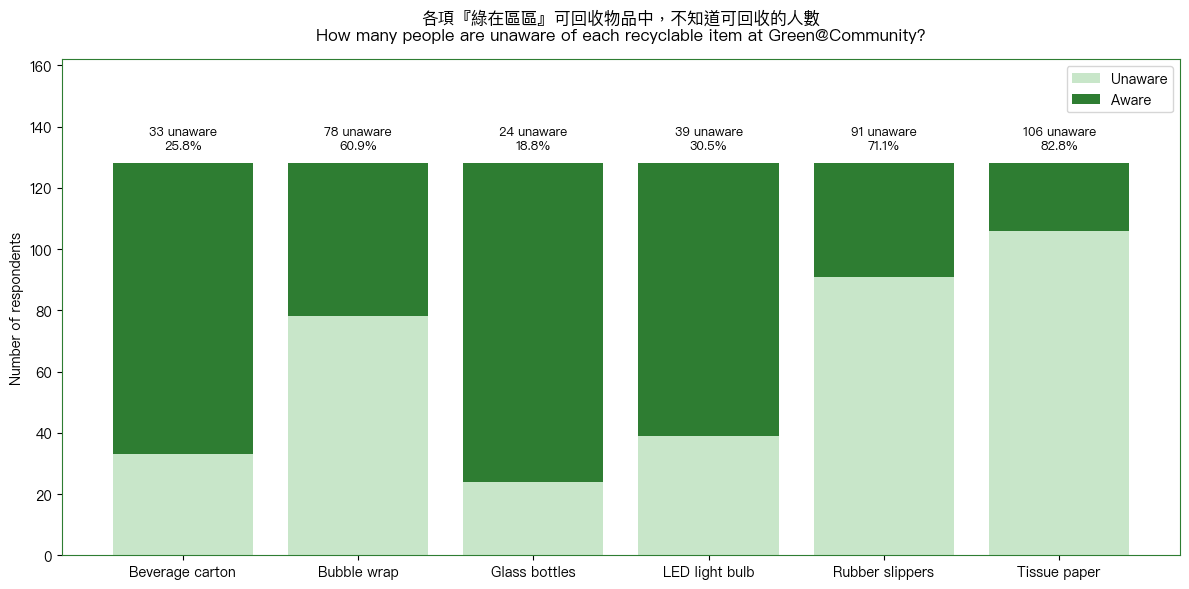

In [19]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys
def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
_ensure("pandas"); _ensure("openpyxl"); _ensure("matplotlib")

# ---------- imports ----------
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path

# ---------- load data ----------
data_path = Path("../GCAP3226 G@C Survey Responses_cleaned data.xlsx")
df = pd.read_excel(data_path, engine="openpyxl")

# ---------- locate the multi-select column (CN / EN header) ----------
patterns = [
    r"identify\s+which\s+of\s+the\s+following\s+item\(s\)\s+can\s+be\s+recycled\s+at\s+green@community\s+facilities",
    r"請指出下列哪些物品可以在.*綠在區區.*設施進行回收",
]
def find_col(columns):
    cols = [(c, re.sub(r"\s+", " ", str(c)).strip()) for c in columns]
    for c, norm in cols:
        if any(re.search(p, norm, flags=re.IGNORECASE) for p in patterns):
            return c
    # last-resort heuristic: contains both "Green@Community" and "recycl"
    for c, norm in cols:
        if re.search(r"green@community", norm, flags=re.IGNORECASE) and \
           re.search(r"recycl", norm, flags=re.IGNORECASE):
            return c
    return None

col = find_col(df.columns)
if col is None:
    raise RuntimeError("Could not find the checkbox column for the recyclable-items question.")

series = df[col].dropna().astype(str)

# ---------- parse responses into sets of options (exclude "Have no idea") ----------
BAD_OPTION = "have no idea"

def parse_items(cell: str):
    items = set()
    for part in cell.split(","):
        opt = part.strip()
        if opt and opt.lower() != BAD_OPTION:
            items.add(opt)
    return items

parsed_rows = [parse_items(v) for v in series]
n_respondents = len(parsed_rows)

# all distinct option labels (taken from CLEANED DATA, excluding "Have no idea")
all_items = sorted(
    opt for opt in set().union(*parsed_rows)
    if opt.lower() != BAD_OPTION
)

# ---------- compute aware / unaware counts for each item ----------
aware_counts   = []
unaware_counts = []

for item in all_items:
    aware = sum(1 for row in parsed_rows if item in row)
    unaware = n_respondents - aware
    aware_counts.append(aware)
    unaware_counts.append(unaware)

# ---------- fonts (Chinese-capable if available) ----------
for font_name in ["Noto Sans CJK TC", "PingFang TC", "PingFang HK",
                  "Microsoft JhengHei", "SimHei"]:
    if any(font_name in f.name for f in matplotlib.font_manager.fontManager.ttflist):
        plt.rcParams["font.family"] = font_name
        break
plt.rcParams["axes.unicode_minus"] = False

# ---------- plot stacked bar chart ----------
fig, ax = plt.subplots(figsize=(12, 6), facecolor="white")
ax.set_facecolor("white")

x = range(len(all_items))
unaware_color = "#c8e6c9"   # light green
aware_color   = "#2e7d32"   # dark green

# draw border in green
border_color = "#2e7d32"
for spine in ax.spines.values():
    spine.set_color(border_color)

bars_unaware = ax.bar(x, unaware_counts, color=unaware_color, label="Unaware")
bars_aware   = ax.bar(x, aware_counts, bottom=unaware_counts,
                      color=aware_color, label="Aware")

# labels: show "unaware" count and % on top of each bar
ymax = max(unaware_counts[i] + aware_counts[i] for i in range(len(all_items)))
ax.set_ylim(0, ymax * 1.25 + 2)

for i, (u, a) in enumerate(zip(unaware_counts, aware_counts)):
    total = u + a
    pct_unaware = (u / total * 100) if total > 0 else 0.0
    ax.text(
        i,
        u + a + ymax * 0.03,
        f"{u} unaware\n{pct_unaware:.1f}%",
        ha="center", va="bottom", fontsize=9
    )

ax.set_xticks(list(x))
ax.set_xticklabels(all_items, rotation=0, ha="center")
ax.set_ylabel("Number of respondents")

title_cn = "各項『綠在區區』可回收物品中，不知道可回收的人數"
title_en = "How many people are unaware of each recyclable item at Green@Community?"
ax.set_title(title_cn + "\n" + title_en, pad=14)

ax.legend(loc="upper right")

plt.tight_layout()
plt.show()
